In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager as fm, rcParams
import seaborn as sns

import xgboost as xgb
from catboost import CatBoostClassifier

from scipy import interp, stats
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
#from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.metrics import log_loss, brier_score_loss
from sklearn.metrics import balanced_accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.metrics import precision_recall_curve

import shap

from PIL import Image
from io import BytesIO
import time
import datetime
import collections
import re, sys, glob, os, pydot
import warnings
warnings.filterwarnings('ignore')
import pickle as pkl

from sklearn.tree import export_graphviz
from IPython import display

In [2]:
print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())
print (plt.rcParams['font.serif'])

plt.rcParams["font.family"] = "serif"
plt.rcParams['font.serif']='Times New Roman'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.dpi"] = 150
rcParams["figure.facecolor"] = 'w'
print (plt.rcParams['font.family'])
print (plt.rcParams['font.serif'])

버전:  3.3.2
설치 위치:  /home/hahnyi/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/__init__.py
설정 위치:  /home/hahnyi/.config/matplotlib
캐시 위치:  /home/hahnyi/.cache/matplotlib
['DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Times New Roman', 'Times', 'Palatino', 'Charter', 'serif']
['serif']
['Times New Roman']


In [3]:
def rf_clf(XTrain, yTrain, XTest, yTest) :
    kappa_scorer = make_scorer(cohen_kappa_score)
    base_fpr = np.linspace(0, 1, 101)
    params = {'criterion': ('gini', 'entropy'), 
              'n_estimators': np.arange(20, 1000, 50), 
              'max_depth': [6, 9, 12], 
              'min_samples_leaf': [3, 6, 9], 
              'min_samples_split': [3, 6, 9, 12],
              'max_features': ['log2'],
              'min_impurity_decrease' : [0.0005], 
              'class_weight': ['balanced']}
    grid = GridSearchCV(RandomForestClassifier(random_state=1311, class_weight = 'balanced'),
                      params, scoring=kappa_scorer, #scoring = 'recall', 
                      cv=StratifiedKFold(), n_jobs = 1311, pre_dispatch="2*n_jobs")
    grid_result = grid.fit(XTrain, yTrain)

    clf_rf = RandomForestClassifier(n_estimators=grid_result.best_params_['n_estimators'], 
                                    criterion=grid_result.best_params_['criterion'], 
                                    random_state=64, class_weight = 'balanced').fit(XTrain, yTrain)
    yPred = clf_rf.predict_proba(XTest)
    fpr, tpr, thr = roc_curve(yTest, yPred[:,1])
    J_youden = tpr - fpr
    thr_opt = thr[np.argmax(J_youden)]
    aucs = auc(fpr, tpr)
    imps = clf_rf.feature_importances_
    logloss = log_loss(yTest, yPred[:,1])
    bscoreloss = brier_score_loss(yTest, yPred[:,1])
    tpr_more = interp(base_fpr, fpr, tpr)
    tpr_more[0] = 0.0
    return fpr, tpr, thr, thr_opt, tpr_more, aucs, logloss, bscoreloss, imps, clf_rf

In [4]:
def catboost_clf(XTrain, yTrain, XTest, yTest) :
    
    kappa_scorer = make_scorer(cohen_kappa_score)
    base_fpr = np.linspace(0, 1, 101)
    
    params = {'learning_rate': [0.01, 0.05],
              'depth': [4, 7, 8, 12],
              #'l2_leaf_reg': [3, 6, 9],
              #'subsample' : [0.5, 0.8, 1],
              #'leaf_estimation_iterations': [10, 20], 
              'loss_function': ['Logloss'], 
              #'max_leaves': [64, 128, 256],
              'eval_metric': ['AUC']}
    clf_cbc = CatBoostClassifier(iterations=300, task_type="CPU", verbose=False, random_state=1311)
    #clf_cbc = CatBoostClassifier(iterations=300, task_type="GPU", devices='0', verbose=False)
    #clf_cbc = CatBoostClassifier(iterations=250, task_type="GPU", devices='2')
    grid_search = RandomizedSearchCV(clf_cbc, params, scoring=kappa_scorer, #scoring = 'recall', 
                                     cv=StratifiedKFold(), n_jobs=48, 
                                     pre_dispatch="2*n_jobs", random_state=1311).fit(XTrain, yTrain)
    best_parameters=grid_search.best_estimator_.get_params()
    clf_cbc = CatBoostClassifier(**best_parameters)
    clf_cbc.fit(XTrain, yTrain)
    #xgb.plot_importance(clf_xgb, title = "top 10 features", max_num_features=10)
    imps = clf_cbc.feature_importances_
    yPred = clf_cbc.predict_proba(XTest)
    fpr, tpr, thr = roc_curve(yTest, yPred[:,1])
    J_youden = tpr - fpr
    thr_opt = thr[np.argmax(J_youden)]
    aucs = auc(fpr, tpr)
    #y_pred = adjusted_classes(y_scores, 0.5)
    #confusion_matrix(yTest, y_pred)
    logloss = log_loss(yTest, yPred[:,1])
    bscoreloss = brier_score_loss(yTest, yPred[:,1])
    tpr_more = interp(base_fpr, fpr, tpr)
    tpr_more[0] = 0.0
    return fpr, tpr, thr, thr_opt, tpr_more, aucs, logloss, bscoreloss, imps, clf_cbc

In [5]:
def adjusted_classes(y_scores, thr):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= thr else 0 for y in y_scores]

In [9]:
start = time.time()
enc = OneHotEncoder()
# fprs, tprs, thrs, aucs
base_fpr = np.linspace(0, 1, 101)

rf_fprs = []
rf_tprs = []
rf_tpr_mores = []
rf_thrs = []
rf_thr_opts = []
rf_aucs = []

cbc_fprs = []
cbc_tprs = []
cbc_tpr_mores = []
cbc_thrs = []
cbc_thr_opts = []
cbc_aucs = []

en_fprs = []
en_tprs = []
en_tpr_mores = []
en_thrs = []
en_thr_opts = []
en_aucs = []

# log_loss
rf_log_loss = []
cbc_log_loss = []
en_log_loss = []

# brier_score_loss
rf_brier_loss = []
cbc_brier_loss= []
en_brier_loss = []

# classifiers
rf_clfs = []
cbc_clfs = []
en_clfs = []

# feature importances
# ann_imps = []
rf_imps = []
cbc_imps = []
svc_imps = []

# Testsets saved
XTests = []
yTests = []

files = glob.glob("imputed_data/troponin_pod1_regression_imputed_data*.csv")
files.sort()
for i, ifile in enumerate(files) :
    
    df = pd.read_csv(ifile, low_memory=False)
    columns2log= ['Tnl_ind', 'Tnl_anhe', 'Tnl_reperfusion']
    for j, col in enumerate(columns2log) :
        df[col] = df[col].apply(np.log)
    df['TnI_pod1'] = df['TnI_pod1'].apply(lambda x: 0 if x < 0.04 else 1)
    X = np.array(df.drop(columns=['TnI_pod1']))
    y = np.array(df.loc[:,'TnI_pod1'])
    print('{:2d}, {}, outcomes class:{}'.format(i+1, ifile, collections.Counter(y)))
    nsplits = 5
    seeds = [1311]
    for j in range(len(seeds)) :
        #print ("{} {} th loop".format(i, j))
        skf = StratifiedKFold(n_splits = nsplits, shuffle = True, 
                              random_state=seeds[j])
        
        for train_index, test_index in skf.split(X,y):
            XTrain, XTest = X[train_index], X[test_index]
            yTrain, yTest = y[train_index], y[test_index]
            unique, counts = np.unique(yTrain, return_counts=True)
            unique, counts = np.unique(yTest, return_counts=True)
            XTests.append(XTest)
            yTests.append(yTest)
            
            
            # random forest classifier
            fpr, tpr, thr, thr_opt, tpr_more, aucs, logloss, bscoreloss, imps, clf_rf = \
                                                             rf_clf(XTrain, yTrain, XTest, yTest)
            rf_fprs.append(fpr)
            rf_tprs.append(tpr)
            rf_tpr_mores.append(tpr_more)
            rf_thrs.append(thr)
            rf_thr_opts.append(thr_opt)
            rf_aucs.append(aucs)
            rf_log_loss.append(logloss)
            rf_brier_loss.append(bscoreloss)
            rf_imps.append(imps)
            rf_clfs.append(clf_rf)
            yPred_rf = clf_rf.predict_proba(XTest)
            
            # catboost classifier
            fpr, tpr, thr, thr_opt, tpr_more, aucs, logloss, bscoreloss, imps, clf_cbc = \
                                                             catboost_clf(XTrain, yTrain, XTest, yTest)
            cbc_fprs.append(fpr)
            cbc_tprs.append(tpr)
            cbc_tpr_mores.append(tpr_more)
            cbc_thrs.append(thr)
            cbc_thr_opts.append(thr_opt)
            cbc_aucs.append(aucs)
            cbc_log_loss.append(logloss)
            cbc_brier_loss.append(bscoreloss)
            cbc_imps.append(imps)
            cbc_clfs.append(clf_cbc)
            yPred_cbc = clf_cbc.predict_proba(XTest)
            
            
            # ensemble classifier 
            base_fpr = np.linspace(0, 1, 101)
            clf_en = VotingClassifier(estimators=[('rf', clf_rf),
                                                   ('cbc', clf_cbc)],
                                     voting='soft', weights=[1,1],
                                     flatten_transform=False)
            clf_en.fit(XTrain, yTrain)
            en_clfs.append(clf_en)
            yPred_en = clf_en.predict_proba(XTest)
            fpr, tpr, thr = roc_curve(yTest, yPred_en[:,1])
            _en_J_youden = tpr - fpr
            _en_thr_opt = thr[np.argmax(_en_J_youden)]
            _en_aucs = auc(fpr, tpr)
            _en_logloss = log_loss(yTest, yPred_en[:,1])
            _en_bscoreloss = brier_score_loss(yTest, yPred_en[:,1])
            _en_tpr = interp(base_fpr, fpr, tpr)
            _en_tpr[0] = 0.0
            en_fprs.append(fpr)
            en_tprs.append(tpr)
            en_thr_opts.append(_en_thr_opt)
            en_tpr_mores.append(_en_tpr)
            en_thrs.append(thr)
            en_aucs.append(_en_aucs)
            en_log_loss.append(_en_logloss)
            en_brier_loss.append(_en_bscoreloss)
            print( yPred_rf.shape, yPred_en.shape)
print("time :", time.time() - start)

 1, imputed_data/troponin_pod1_regression_imputed_data01.csv, outcomes class:Counter({1: 714, 0: 536})


NameError: name 'rf_clf' is not defined

In [7]:
import sys, math
from scipy import stats

def tidy(x, n):
    """Return 'x' rounded to 'n' significant digits."""
    y=abs(x)
    if y <= sys.float_info.min: return 0.0
    return round( x, int( n-math.ceil(math.log10(y)) ) )

def mean_confidence_interval(data, lb = " ", confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return str(tidy(m,3))+ lb +"("+str(tidy(m-h,3))+\
           " – "+str(format(tidy(m+h,3), ".3f")+")")

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


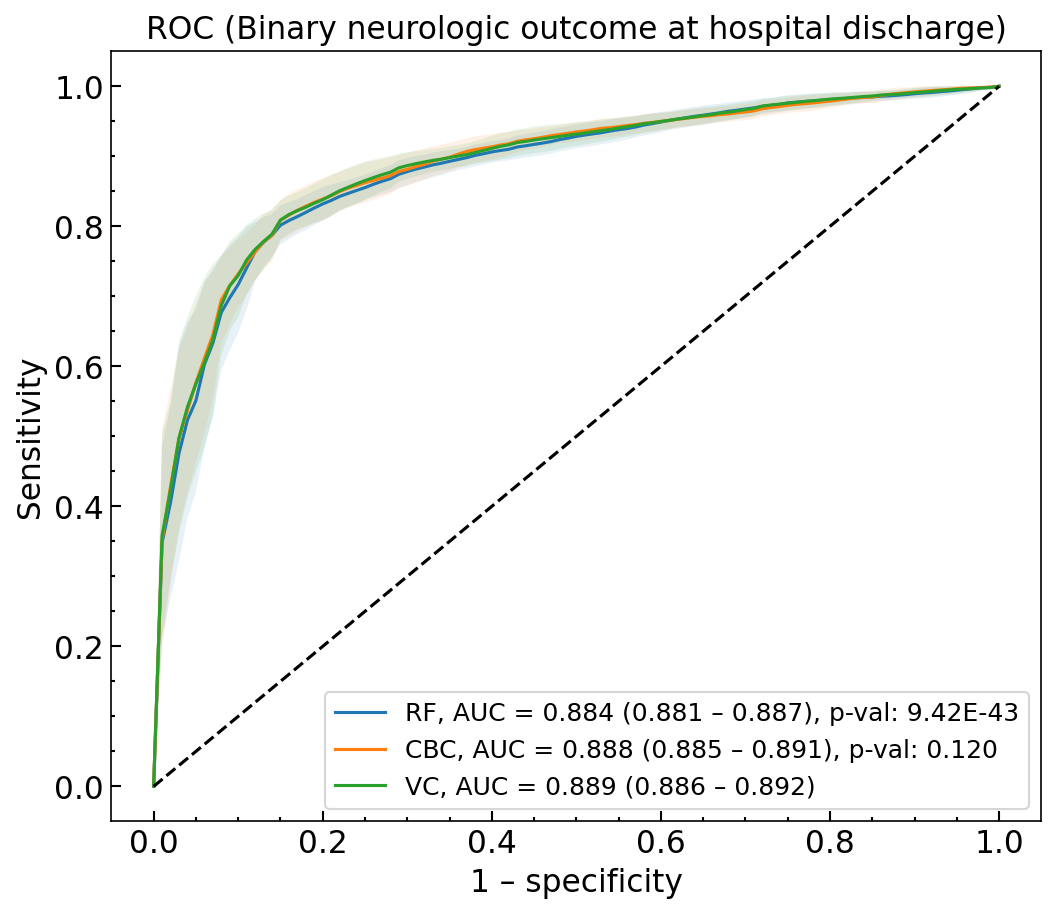

In [13]:
target = df.columns[0]

fig = plt.figure(figsize=(8.0, 6.8))    
ax = fig.add_subplot(1, 1, 1) 

#base_fpr = np.linspace(0, 1, 101)

tpr_more = interp(base_fpr, fpr, tpr)

# SWAP_tprs = np.array(swap_tpr_mores)
# SWAP_mean_tprs = SWAP_tprs.mean(axis=0)
# SWAP_std = SWAP_tprs.std(axis=0)
# SWAP_tprs_upper = np.minimum(SWAP_mean_tprs + SWAP_std, 1)
# SWAP_tprs_lower = SWAP_mean_tprs - SWAP_std
# ax.plot(base_fpr, SWAP_mean_tprs, label = 'SWAP AUC = {}'.format(mean_confidence_interval(swap_aucs)))
# ax.fill_between(base_fpr, SWAP_tprs_lower, SWAP_tprs_upper, alpha=0.1)

# LogisticRegressionClassfier
# LR_tprs = np.array(rlr_tpr_mores)
# LR_aucs = np.array(rlr_aucs)
# LR_mean_tprs = LR_tprs.mean(axis=0)
# LR_std = LR_tprs.std(axis=0)
# LR_tprs_upper = np.minimum(LR_mean_tprs + LR_std, 1)
# LR_tprs_lower = LR_mean_tprs - LR_std


# RandomForestClassifier
RF_tprs = np.array(rf_tpr_mores)
RF_aucs = np.array(rf_aucs)
RF_mean_tprs = RF_tprs.mean(axis=0)
RF_std = RF_tprs.std(axis=0)
RF_tprs_upper = np.minimum(RF_mean_tprs + RF_std, 1)
RF_tprs_lower = RF_mean_tprs - RF_std


# XGboostClassifier
# XGB_tprs = np.array(xgb_tpr_mores)
# XGB_aucs = np.array(xgb_aucs)
# XGB_mean_tprs = XGB_tprs.mean(axis=0)
# XGB_std = XGB_tprs.std(axis=0)
# XGB_tprs_upper = np.minimum(XGB_mean_tprs + XGB_std, 1)
# XGB_tprs_lower = XGB_mean_tprs - XGB_std


# CatboostClassifier
CBC_tprs = np.array(cbc_tpr_mores)
CBC_aucs = np.array(cbc_aucs)
CBC_mean_tprs = CBC_tprs.mean(axis=0)
CBC_std = CBC_tprs.std(axis=0)
CBC_tprs_upper = np.minimum(CBC_mean_tprs + CBC_std, 1)
CBC_tprs_lower = CBC_mean_tprs - CBC_std

# EnsembleClassifier
EN_tprs = np.array(en_tpr_mores)
EN_aucs = np.array(en_aucs)
EN_mean_tprs = EN_tprs.mean(axis=0)
EN_std = EN_tprs.std(axis=0)
EN_tprs_upper = np.minimum(EN_mean_tprs + EN_std, 1)
EN_tprs_lower = EN_mean_tprs - EN_std


# comparing VC with Lositics regression
# _, pvalue1 = stats.ttest_rel(LR_aucs, EN_aucs)
# pval1 = '{0:1.2E}'.format(pvalue1)
# # # comparing VC with Artificial Neural Network
# # _, pvalue2 = stats.ttest_rel(ANN_aucs, EN_aucs)
# # pval2 = '{0:1.2E}'.format(pvalue2)
# # comparing VC with RandomForest
_, pvalue3 = stats.ttest_rel(RF_aucs, EN_aucs)
pval3 = '{0:1.2E}'.format(pvalue3)
# # comparing VC with XGB
_, pvalue4 = stats.ttest_rel(CBC_aucs, EN_aucs)
pval4 = '{0:.3f}'.format(pvalue4)

# plots
# ax.plot(base_fpr, LR_mean_tprs, 
#         label = 'RLR, AUC = {}'.format(mean_confidence_interval(LR_aucs)))
# #         label = 'RLR, AUC = {}, {}'.format(mean_confidence_interval(LR_aucs), '$\mathit{p}$ < 0.001'))
# ax.fill_between(base_fpr, LR_tprs_lower, LR_tprs_upper, alpha=0.1)

# # ax.plot(base_fpr, ANN_mean_tprs, 
# #         label = 'ANN, AUC = {}, p{}'.format(mean_confidence_interval(ANN_aucs), '<0.001'))
# # ax.fill_between(base_fpr, ANN_tprs_lower, ANN_tprs_upper, alpha=0.1)

ax.plot(base_fpr, RF_mean_tprs, 
        label = 'RF, AUC = {}, p-val: {}'.format(mean_confidence_interval(RF_aucs), pval3))
        #label = 'RF, AUC = {}, {}'.format(mean_confidence_interval(RF_aucs), '$\mathit{p}$ < 0.001'))
ax.fill_between(base_fpr, RF_tprs_lower, RF_tprs_upper, alpha=0.1)

# ax.plot(base_fpr, XGB_mean_tprs, 
#         label = 'XGB, AUC = {}'.format(mean_confidence_interval(XGB_aucs)))
#         #label = 'XGB, AUC = {}, {}'.format(mean_confidence_interval(XGB_aucs), '$\mathit{p}$ = 0.018'))
#         #label = 'XGB, AUC = {}'.format(mean_confidence_interval(XGB_aucs)))
# ax.fill_between(base_fpr, XGB_tprs_lower, XGB_tprs_upper, alpha=0.1)

ax.plot(base_fpr, CBC_mean_tprs, 
        label = 'CBC, AUC = {}, p-val: {}'.format(mean_confidence_interval(CBC_aucs), pval4))
        #label = 'CBC, AUC = {}, {}'.format(mean_confidence_interval(CBC_aucs), '$\mathit{p}$ = 0.018'))
        #label = 'XGB, AUC = {}'.format(mean_confidence_interval(XGB_aucs)))
ax.fill_between(base_fpr, CBC_tprs_lower, CBC_tprs_upper, alpha=0.1)

ax.plot(base_fpr, EN_mean_tprs, 
        label = 'VC, AUC = {}'.format(mean_confidence_interval(EN_aucs)))
ax.fill_between(base_fpr, EN_tprs_lower, EN_tprs_upper, alpha=0.1)

ax.plot([0, 1], [0, 1], 'k--')    
ax.set_ylabel("Sensitivity", fontsize=15)
ax.set_xlabel("1 – specificity", fontsize=15)
ax.legend(loc='best', fontsize=12)
ax.set_title("ROC (Binary neurologic outcome at hospital discharge)", fontsize=15)
ax.minorticks_on()
ax.tick_params(which='major', length=5, width=1, direction='in')
ax.tick_params(which='minor', length=2, width=1, direction='in')
ax.tick_params(labelsize = 15)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.grid(False)
png1 = BytesIO()
plt.savefig(png1, dpi=600, format='png')

# load this image into PIL
png2 = Image.open(png1)
#save as TIFF
png2.save('Figures/figure1.tif')
png1.close()
png2.close()
plt.savefig("Figures/figure1")
plt.show()

In [28]:
def find_all_keys(dict1, fclass) :
    founds = []
    for k, v in dict1.items() :
        if v == fclass :
            founds.append(k)
    return founds


def performance_model(cm) :
    
    recall = cm.iloc[1,1] / (cm.iloc[1,0] + cm.iloc[1,1]) 
    precision = cm.iloc[0,0] / (cm.iloc[0,0] + cm.iloc[0,1])
    ppv = cm.iloc[1,1] / (cm.iloc[0,1] + cm.iloc[1,1])
    npv = cm.iloc[0,0] / (cm.iloc[0,0] + cm.iloc[1,0])
    fmeasure = 2 * (precision * recall) / (precision + recall)
    return [recall, precision, ppv, npv, fmeasure]


def nri_models(predA_done, predB_done, TRue) :
    # test : predA_done
    # control : predB_done
    # true : TRue
    dictA = dict(enumerate(predA_done))
    dictB = dict(enumerate(predB_done))
    dictT = dict(enumerate(TRue))
    if len(dictA) == len(dictB) and len(dictB) == len(dictT) :
        # Event
        setA = set(find_all_keys(dictA, 1))
        setB = set(find_all_keys(dictB, 1))
        setT = set(find_all_keys(dictT, 1))
        setAT = setA & setT
        setBT = setB & setT
        nri_event = (len(setAT - setBT) - len(setBT - setAT)) / len(setT)
        # Non-event
        setA = set(find_all_keys(dictA, 0))
        setB = set(find_all_keys(dictB, 0))
        setT = set(find_all_keys(dictT, 0))
        setAT = setA & setT
        setBT = setB & setT
        nri_nonevent = (len(setAT - setBT) - len(setBT - setAT)) / len(setT)
        return nri_event + nri_nonevent 
    else :
        return np.nan

In [31]:
# Sensitivity, Specificity, Positive Predictive Value, Negative Predictive Value, F-measure, NRI
perform2 = [] # rf
perform4 = [] # cbc
perform5 = [] # en

for i, (clf2, clf4, clf5) in enumerate(zip(rf_clfs, cbc_clfs, en_clfs)) :
    
    # rf
    pred2 = clf2.predict_proba(XTests[i])
    pred2_done = adjusted_classes(pred2[:,1], rf_thr_opts[i])
    cm2 = pd.DataFrame(confusion_matrix(yTests[i], pred2_done))
    if i == 0:
        cm_rf = cm2
    else :
        cm_rf = cm_rf+cm2
    kappa = cohen_kappa_score(yTests[i], pred2_done, labels=None, weights=None)
    _perform2 = performance_model(cm2)
    _perform2.append(kappa)
    
    
    # cbc
    pred4 = clf4.predict_proba(XTests[i])
    pred4_done = adjusted_classes(pred4[:,1], cbc_thr_opts[i])
    cm4 = pd.DataFrame(confusion_matrix(yTests[i], pred4_done))
    if i == 0:
        cm_cbc = cm4
    else :
        cm_cbc = cm_cbc+cm4
    kappa = cohen_kappa_score(yTests[i], pred4_done, labels=None, weights=None)
    _perform4 = performance_model(cm4)
    _perform4.append(kappa)
    
    # en
    pred5 = clf5.predict_proba(XTests[i])
    pred5_done = adjusted_classes(pred5[:,1], en_thr_opts[i])
    cm5 = pd.DataFrame(confusion_matrix(yTests[i], pred5_done))
    if i == 0:
        cm_vc = cm5
    else :
        cm_vc = cm_vc+cm5
    kappa = cohen_kappa_score(yTests[i], pred5_done, labels=None, weights=None)
    _perform5 = performance_model(cm5)
    _perform5.append(kappa)
    
    # NRI
    _perform4.append(nri_models(pred4_done, pred2_done, yTests[i]))
    _perform5.append(nri_models(pred5_done, pred2_done, yTests[i]))
    
    perform2.append(np.array(_perform2))
    perform4.append(np.array(_perform4))
    perform5.append(np.array(_perform5))
    
mat2 = np.array(perform2).transpose()
mat4 = np.array(perform4).transpose()
mat5 = np.array(perform5).transpose()


# try :
#     rlr_ppv = mean_confidence_interval(mat1[2])
# except ValueError:
#     rlr_ppv = "n.a."
    
df_perf = pd.DataFrame(columns = ['Metrics', 'RF', 'CBC', 'VC'])
                      
Metrics = ['Sensitivity', 'Specificity', 'PPV', 'NPV', 'F1-score', 'Kappa', 'NRI']
for j in range(7) :
    if j == 6 :
        df_perf.loc[len(df_perf)] = [Metrics[j], np.nan,
                                    #mean_confidence_interval(mat2[j], lb=" "),
                                    mean_confidence_interval(mat4[j], lb=" "),
                                    mean_confidence_interval(mat5[j], lb=" ")]
    else :
        df_perf.loc[len(df_perf)] = [Metrics[j],
                                    mean_confidence_interval(mat2[j], lb=" "),
                                    mean_confidence_interval(mat4[j], lb=" "),
                                    mean_confidence_interval(mat5[j], lb=" ")]
    
df_perf.set_index('Metrics').to_csv("metrics.csv")

In [32]:
df_perf

,Metrics,RF,CBC,VC
0,Sensitivity,0.795 (0.789 – 0.800),0.803 (0.797 – 0.808),0.805 (0.799 – 0.811)
1,Specificity,0.882 (0.875 – 0.888),0.872 (0.866 – 0.878),0.873 (0.867 – 0.879)
2,PPV,0.901 (0.896 – 0.906),0.895 (0.891 – 0.899),0.896 (0.892 – 0.900)
3,NPV,0.764 (0.76 – 0.768),0.77 (0.765 – 0.774),0.772 (0.767 – 0.777)
4,F1-score,0.835 (0.832 – 0.837),0.835 (0.832 – 0.837),0.836 (0.833 – 0.839)
5,Kappa,0.663 (0.658 – 0.669),0.664 (0.659 – 0.669),0.667 (0.661 – 0.673)
6,NRI,NaN,-0.0012 (-0.00392 – 0.002),0.00199 (0.000132 – 0.004)


In [33]:
(cm_rf / (i+1)).to_csv("rf_cm.csv")
(cm_cbc / (i+1)).to_csv("cbc_cm.csv")
(cm_vc / (i+1)).to_csv("vc_cm.csv")

In [105]:
cm_vc / (i+1)

,0,1
0,14045,2035
1,4181,17239


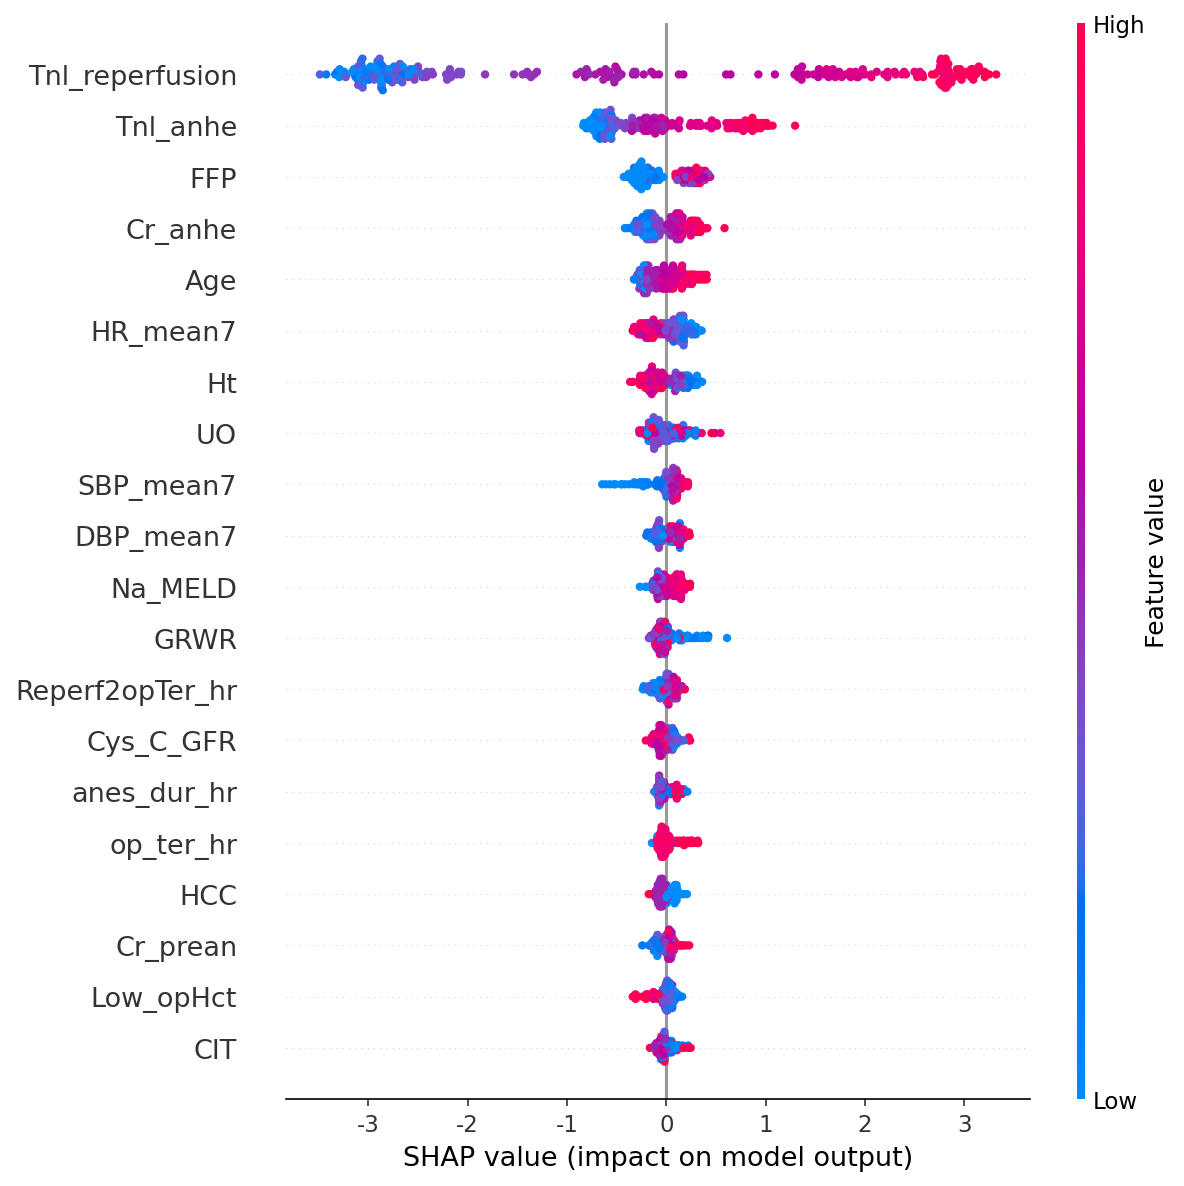

In [83]:
shap.initjs()
explainer = shap.TreeExplainer(cbc_clfs[0])
df_template = df.drop(columns=['TnI_pod1'])
df_XTest = pd.DataFrame(data=XTests[0], columns=df_template.columns)
shap_values = explainer.shap_values(df_XTest)
#shap.summary_plot(shap_values, df_XTest, plot_type='bar')
shap.summary_plot(shap_values, df_XTest)

In [102]:
shap.force_plot(explainer.expected_value, shap_values, df_XTest)

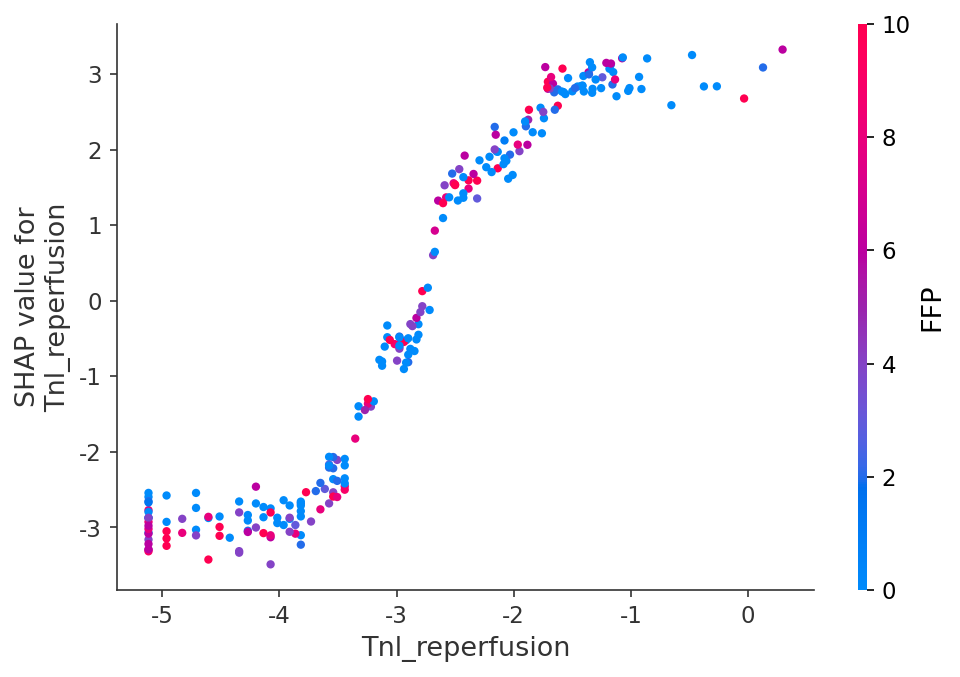

In [103]:
shap.dependence_plot("Tnl_reperfusion", shap_values, df_XTest)

#### Individual analysis

In [100]:
for j, cbc_clf in enumerate(cbc_clfs) :
    if j == 0 :
        pred = cbc_clf.predict_proba(XTests[j])
        pred_thr = adjusted_classes(pred[:,1], cbc_thr_opts[j])
        cm = confusion_matrix(yTests[j], pred_thr)
        
for j, pred_jth in enumerate(pred_thr) :
    if yTests[0][j] != pred_jth :
        print(j, yTests[0][j], pred_jth)

11 1 0
23 1 0
28 1 0
31 1 0
45 1 0
53 0 1
68 0 1
70 0 1
74 1 0
78 1 0
81 1 0
82 1 0
89 1 0
90 1 0
94 1 0
98 1 0
102 1 0
103 1 0
113 1 0
124 1 0
130 1 0
138 1 0
147 1 0
149 1 0
157 1 0
164 1 0
181 1 0
195 1 0
201 1 0
202 0 1
216 1 0
234 0 1
236 1 0
242 1 0
243 0 1
244 1 0
249 1 0


In [101]:
for j, pred_jth in enumerate(pred_thr) :
    if yTests[0][j] == pred_jth :
        print(j, yTests[0][j], pred_jth)

0 1 1
1 1 1
2 0 0
3 0 0
4 0 0
5 1 1
6 1 1
7 1 1
8 1 1
9 1 1
10 0 0
12 0 0
13 1 1
14 1 1
15 0 0
16 0 0
17 0 0
18 0 0
19 0 0
20 1 1
21 0 0
22 0 0
24 1 1
25 0 0
26 1 1
27 1 1
29 0 0
30 1 1
32 1 1
33 1 1
34 1 1
35 1 1
36 1 1
37 1 1
38 1 1
39 1 1
40 1 1
41 0 0
42 1 1
43 0 0
44 0 0
46 1 1
47 1 1
48 0 0
49 0 0
50 1 1
51 0 0
52 0 0
54 0 0
55 0 0
56 1 1
57 0 0
58 1 1
59 0 0
60 1 1
61 0 0
62 1 1
63 0 0
64 0 0
65 1 1
66 0 0
67 1 1
69 1 1
71 1 1
72 1 1
73 0 0
75 1 1
76 1 1
77 1 1
79 0 0
80 0 0
83 0 0
84 0 0
85 1 1
86 1 1
87 0 0
88 1 1
91 0 0
92 0 0
93 1 1
95 1 1
96 0 0
97 1 1
99 0 0
100 1 1
101 1 1
104 1 1
105 0 0
106 0 0
107 1 1
108 0 0
109 0 0
110 1 1
111 0 0
112 1 1
114 0 0
115 0 0
116 0 0
117 1 1
118 0 0
119 0 0
120 0 0
121 0 0
122 1 1
123 1 1
125 1 1
126 0 0
127 0 0
128 0 0
129 1 1
131 1 1
132 0 0
133 1 1
134 0 0
135 1 1
136 0 0
137 1 1
139 0 0
140 1 1
141 0 0
142 0 0
143 1 1
144 1 1
145 0 0
146 0 0
148 1 1
150 0 0
151 0 0
152 1 1
153 0 0
154 1 1
155 1 1
156 0 0
158 1 1
159 0 0
160 1 1
161 0 

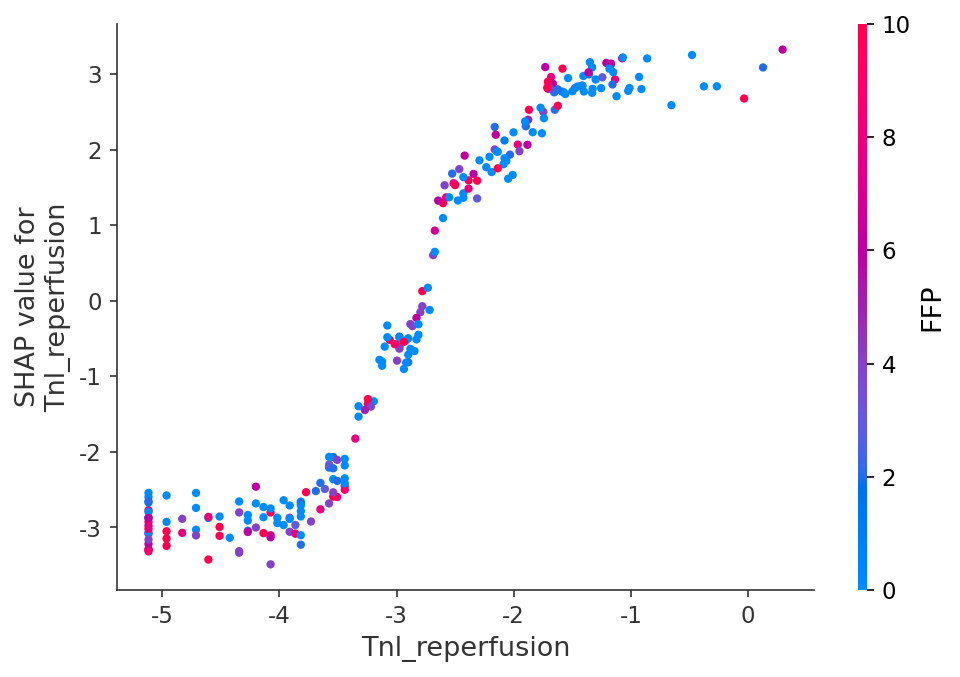

True positive case ( Observation= 1 , Prediction= 1 )


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


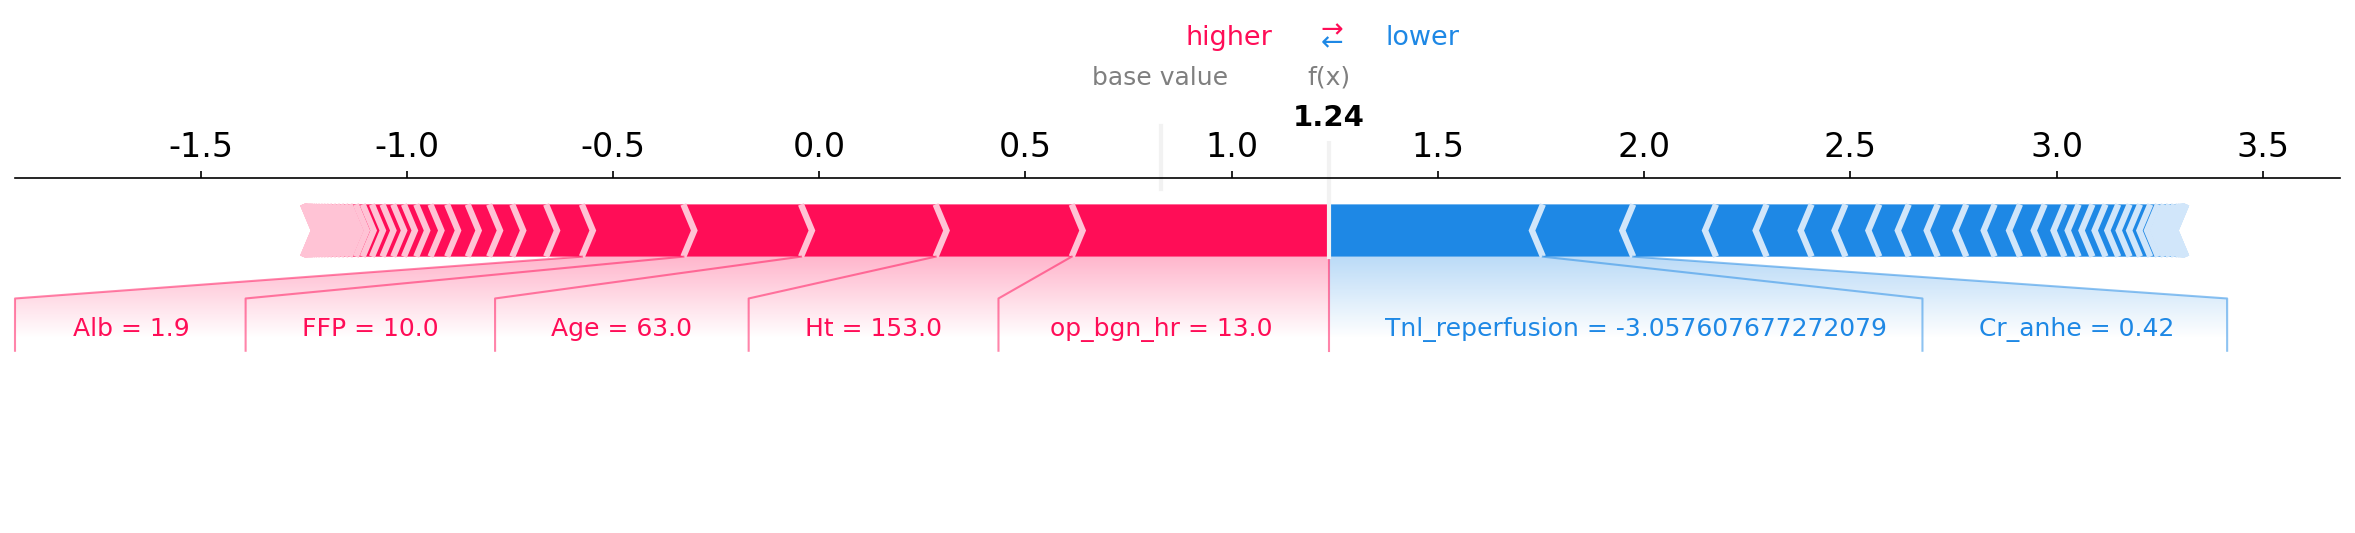

In [106]:
print('True positive case ( Observation=', 1, ', Prediction=', 1, ')')
shap.force_plot(explainer.expected_value, shap_values[0,:], df_XTest.loc[0,:], matplotlib=True)

True negative case ( Observation= 0 , Prediction= 0 )


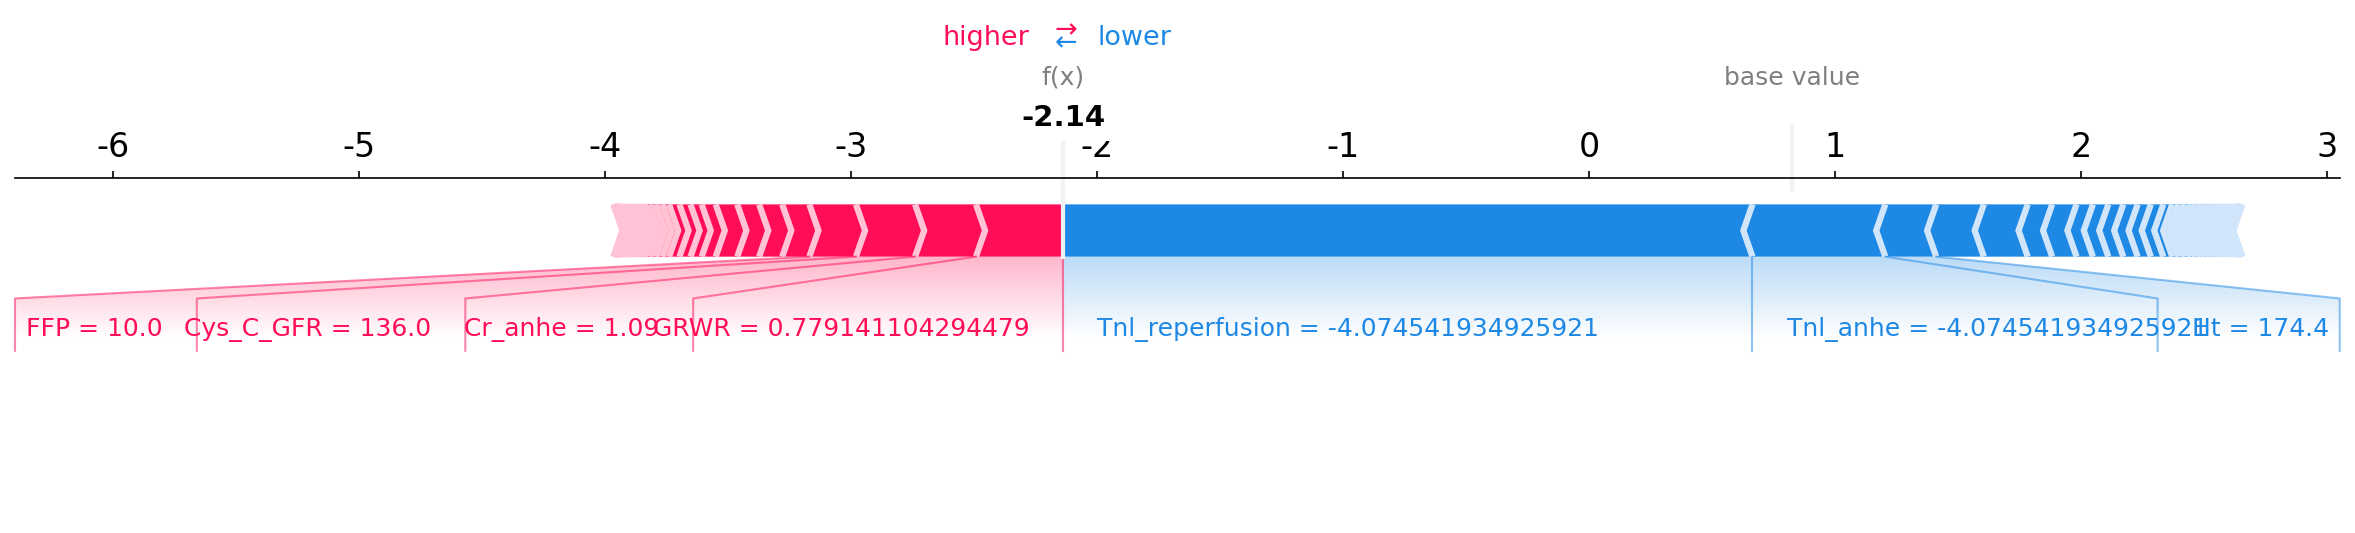

In [107]:
print('True negative case ( Observation=', 0, ', Prediction=', 0, ')')
shap.force_plot(explainer.expected_value, shap_values[2,:], df_XTest.loc[2,:], matplotlib=True)

False negative case ( Observation: 1 , Prediction: 0 )


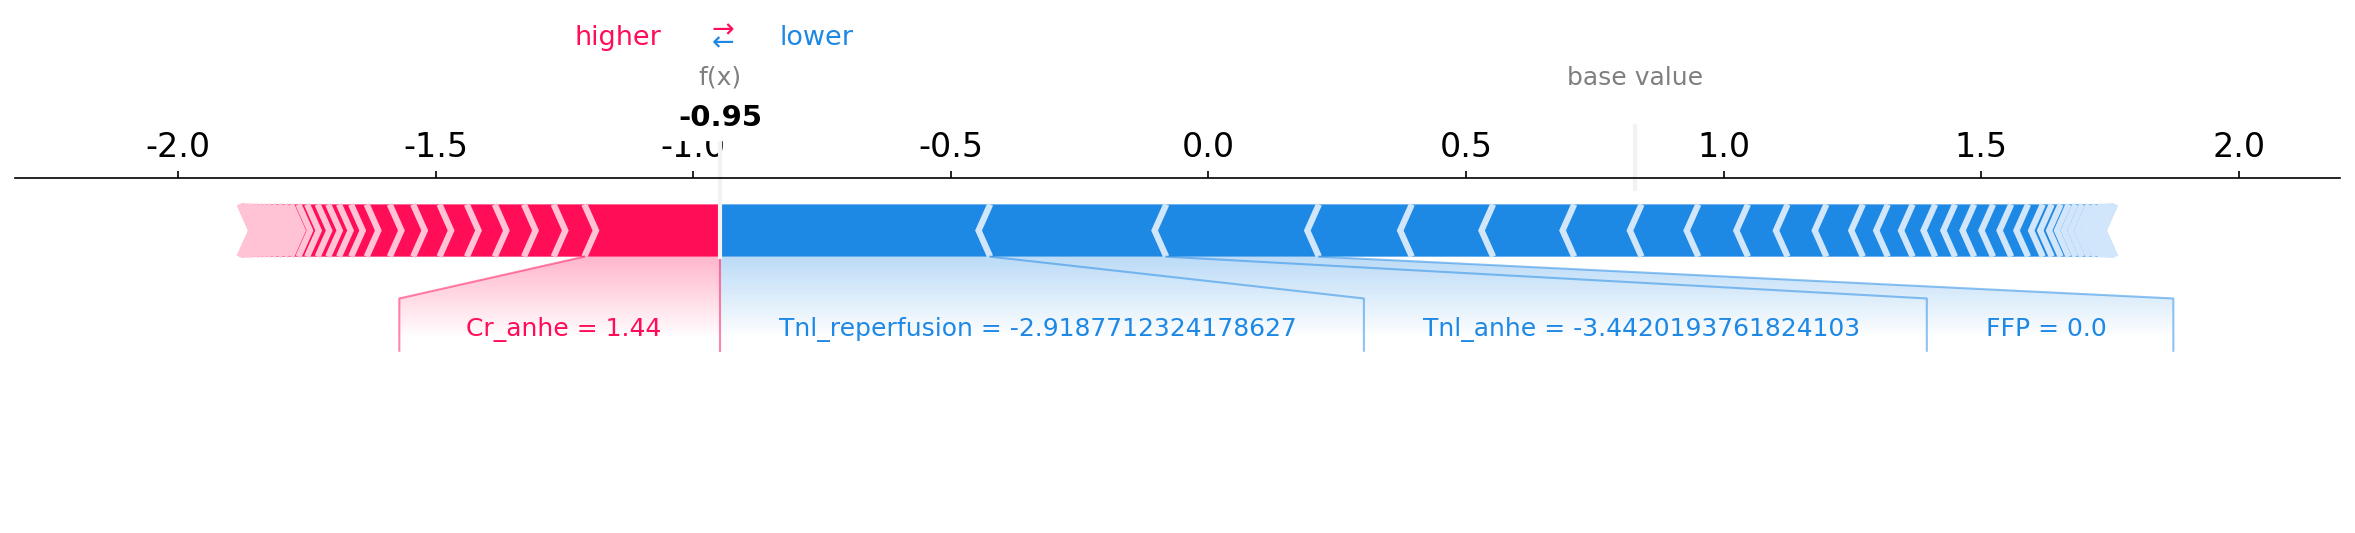

In [108]:
print('False negative case ( Observation:', 1, ', Prediction:', 0, ')')
shap.force_plot(explainer.expected_value, shap_values[11,:], df_XTest.loc[11,:], matplotlib=True)

False positive case ( Observation= 0 , Prediction= 1 )


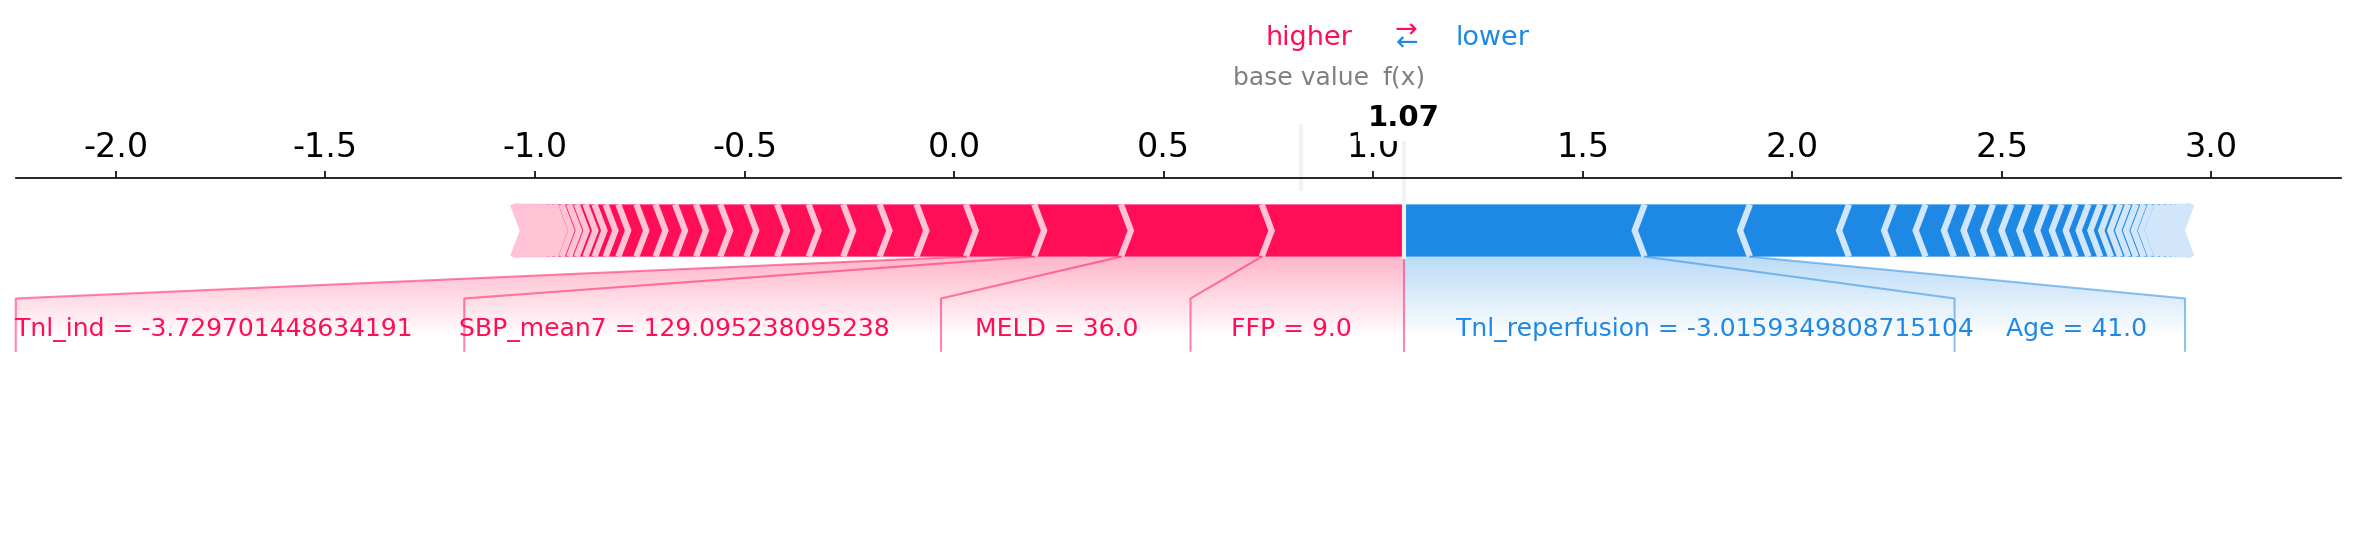

In [109]:
print('False positive case ( Observation=', 0, ', Prediction=', 1, ')')
shap.force_plot(explainer.expected_value, shap_values[53,:], df_XTest.loc[53,:], matplotlib=True)